# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import pandas as pd

# Load Data and Preprocessing

In [2]:
from loadAndPreprocess import load_and_preprocess

'''
well_info: Well, X, Y, Total Resources
sensor_data: Depth, Porosity, Hydrate Saturation, Estimated Resources
'''
well_info, sensor_data_list = load_and_preprocess()

# Kriging 2D Interpolation

In [3]:
X = well_info['X']
Y = well_info['Y']

# Define grid points for interpolation
grid_x = np.arange(min(X)-200, max(X)+200, 1.0)
grid_y = np.arange(min(Y)-200, max(Y)+200, 1.0)

### Kriging Interpolation of Total Resources

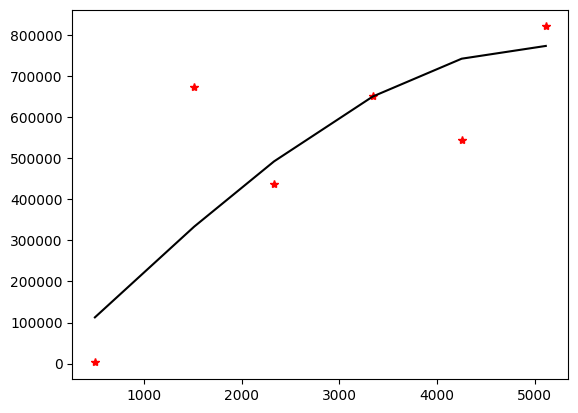

In [4]:
from pykrige.ok import OrdinaryKriging

values = (well_info['Total Resources'])

ok_res = OrdinaryKriging(
    X,
    Y,
    values,
    variogram_model='spherical',
    enable_plotting=True
)

In [5]:
# Perform the interpolation
z_res, ss_res = ok_res.execute('grid', grid_x, grid_y)

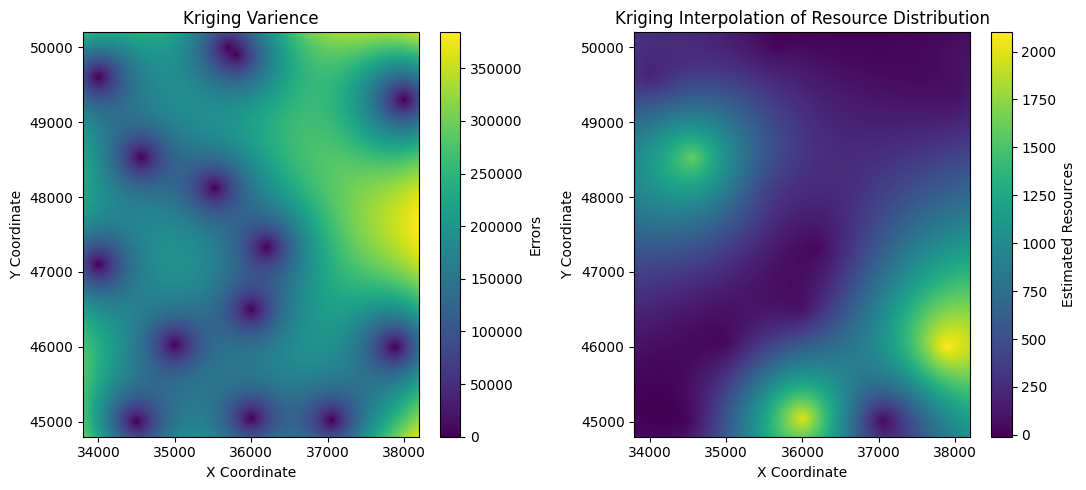

In [6]:
# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(11, 5))  # 1 row, 2 columns

# Plot the first kriging result on the first subplot
c1 = axs[0].pcolormesh(grid_x, grid_y, ss_res, shading='auto')
fig.colorbar(c1, ax=axs[0], label='Errors')
axs[0].set_xlabel('X Coordinate')
axs[0].set_ylabel('Y Coordinate')
axs[0].set_title('Kriging Varience')

# Plot the second kriging result on the second subplot
c2 = axs[1].pcolormesh(grid_x, grid_y, z_res, shading='auto')
fig.colorbar(c2, ax=axs[1], label='Estimated Resources')
axs[1].set_xlabel('X Coordinate')
axs[1].set_ylabel('Y Coordinate')
axs[1].set_title('Kriging Interpolation of Resource Distribution')

# Show the plot
plt.tight_layout()
plt.show()

In [7]:
# Calculate the sum of the estimated resources
estimated_resources = np.sum(z_res) * 4
print(f'The estimated resources is {estimated_resources}')

The estimated resources is 50355145428.42452
